In [1]:
# %%
# Imports and Settings
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import scipy
import torch
import scanpy as sc
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import PyComplexHeatmap as pch
import scvi
import gseapy
import glasbey
from colorspacious import cspace_convert
import anndata
import re

# antipode & utils
import antipode
from antipode.antipode_model import ANTIPODE
from antipode.model_functions import (
    get_real_leaf_means, numpy_hardmax, group_aggr_anndata
)
from antipode.train_utils import *
from antipode.plotting import get_prerank_from_mat
from genomics import sc_analysis  # from your mts‑utils

# %%
# Device & Figure Defaults
sc.settings.figdir = os.path.expanduser('~/WbFigures/DevFinalAnalysis')
sc._settings.settings._vector_friendly = True

plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.family': 'DejaVu Sans',
    'font.sans-serif': 'DejaVuSansMono',
    'pdf.fonttype': 42
})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")
if device.type == 'cuda':
    print("GPU count:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0))

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on cpu


In [2]:
# Configuration
model_tag   = '1.9.1.8.5_Dev_final_600clusters'
model_path  = Path('/home/matthew.schmitz/Matthew/models') / model_tag
leaf_key    = 'level_2'
batch_key   = 'batch_name'
discov_key  = 'species'
layer_key   = 'spliced'
MDE_KEY     = 'X_antipode_UMAP'
annotation_path = '/home/matthew.schmitz/Matthew/data/taxtest/annotations/'
gl_path = '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/'


In [3]:
# %%
# 1) Load backed AnnData (only uns & obs)
data_uns = antipode.anndata_utils.read_h5ad_backed_selective(
    '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_cere_clean_nodoublets.h5ad',
    mode='r',
    selected_keys=['uns','general_region','index','_index','obs']
)
# clean index
data_uns.obs.index = (
    data_uns.obs.index
      .to_series().astype(str)
      .str.replace(r'-\d+$','',regex=True)
)
data_uns.obs.index = (
    data_uns.obs.index
      .to_series().astype(str)
      .str.replace(r'-\d+$','',regex=True)
)

# %%
# 2) Load full AnnData + model
adata = sc.read_h5ad(model_path/'p3_adata.h5ad')#,backed='r')
model = ANTIPODE.load(str(model_path), prefix='p3_', device=device, adata=adata)
model.save_params_to_uns()

adata = model.adata_manager.adata
adata.obs.index = adata.obs.index.to_series().str.replace(r'-\d+$','',regex=True)
adata.obs.index = adata.obs.index.to_series().str.replace(r'-\d+$','',regex=True)



/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


INFO     Generating sequential column names                                                                        


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/pyro/params/param_store.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

In [4]:
# 2.5) Fix some metadata stuff

def longest_atcgn_stretch(series: pd.Series) -> pd.Series:
    pattern = re.compile(r"[ATCGN]+")
    def _longest(s: str) -> str:
        if not isinstance(s, str):
            return ""
        matches = pattern.findall(s.upper())
        return max(matches, key=len) if matches else ""
    return series.map(_longest)
adata.obs['clean_cellname'] = longest_atcgn_stretch(adata.obs.index)

shared_index = adata.obs.index[adata.obs.index.isin(data_uns.obs.index)]
for c in data_uns.obs.columns:
    print(c)
    if not c in adata.obs.columns:
        adata.obs[c] = np.nan
    if adata.obs[c].dtype == 'category':
        data_uns.obs[c] = data_uns.obs[c].astype('category')
        new_cats = list(set(data_uns.obs.loc[shared_index,c].cat.categories) - set(adata.obs.loc[shared_index,c].cat.categories))
        if len(new_cats)>0:
            adata.obs[c] = adata.obs[c].cat.add_categories(new_cats)
        data_uns.obs[c] = data_uns.obs[c].astype(str)
        adata.obs[c] = adata.obs[c].astype(str)
    try:
        adata.obs.loc[shared_index,c] = data_uns.obs.loc[shared_index,c]
    except:
        print('failed')

G2M_score
S_score
batch_name
clean_cellname
dataset_name


/scratch/fast/1413735/ipykernel_2855688/92079768.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['GSE123335_cortex', 'GSE123335_cortex', 'GSE123335_cortex', 'GSE123335_cortex', 'GSE123335_cortex', ..., '10.1038/s41467-023-43568-6', '10.1038/s41467-023-43568-6', '10.1038/s41467-023-43568-6', '10.1038/s41467-023-43568-6', '10.1038/s41467-023-43568-6']
Length: 1765691
Categories (13, object): ['10.1016/j.stem.2021.11.009', '10.1038/s41467-023-43568-6', '10.1038/s41586-019-1917-5', '10.1038/s41586-021-03910-8', ..., 'PRJNA411878_10x_mouse', 'PRJNA547712_dev_hypothalamus', 'PRJNA637987_lamanno_devmouse', 'Schmitz et al. (this publication)']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[shared_index,c] = data_uns.obs.loc[shared_index,c]


doublet
full_cellname


/scratch/fast/1413735/ipykernel_2855688/92079768.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[b'TAGTATGTAATA_e14-WT8-1' b'TTCGCATAGGTT_e14-WT8-1'
 b'CCTCCAATTGGC_e14-WT8-1' ...
 b'TTTGTCACAGACGCAA_SRR13565274_GSM5047783_GW21-04_cerebellum_Homo_sapiens_RNA-Seq_kOut'
 b'TTTGTCACATAACCTG_SRR13565274_GSM5047783_GW21-04_cerebellum_Homo_sapiens_RNA-Seq_kOut'
 b'TTTGTCATCGGTTCGG_SRR13565274_GSM5047783_GW21-04_cerebellum_Homo_sapiens_RNA-Seq_kOut']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[shared_index,c] = data_uns.obs.loc[shared_index,c]


general_region
individual


/scratch/fast/1413735/ipykernel_2855688/92079768.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['e14-WT8', 'e14-WT8', 'e14-WT8', 'e14-WT8', 'e14-WT8', ..., 'SRR13565274_GSM5047783_GW21-04_cerebellum_Hom..., 'SRR13565274_GSM5047783_GW21-04_cerebellum_Hom..., 'SRR13565274_GSM5047783_GW21-04_cerebellum_Hom..., 'SRR13565274_GSM5047783_GW21-04_cerebellum_Hom..., 'SRR13565274_GSM5047783_GW21-04_cerebellum_Hom...]
Length: 1765691
Categories (100, object): ['CS12', 'CS13', 'CS14', 'CS15', ..., 'p0-WT2', 'p0-WT3', 'p0-WT4', 'p07']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[shared_index,c] = data_uns.obs.loc[shared_index,c]


log10_n_counts
msregion


/scratch/fast/1413735/ipykernel_2855688/92079768.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['nan', 'nan', 'nan', 'nan', 'nan', ..., 'nan', 'nan', 'nan', 'nan', 'nan']
Length: 1765691
Categories (18, object): ['cerebellum', 'cge', 'choroid', 'hippo', ..., 'somato', 'temporal', 'thalamus', 'v1']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[shared_index,c] = data_uns.obs.loc[shared_index,c]


n_counts
n_genes
percent_ribo
phase
region
singlet
species
timepoint
failed


In [5]:
# adata.obs['dataset_name'] = adata.obs['dataset_name'].cat.add_categories(['PRJNA641653'])
adata.obs.loc[adata.obs['dataset_name'].isna()&adata.obs.index.str.contains('SRR1208|SRR1440'),'dataset_name'] = 'PRJNA641653'
adata.obs['dataset_name'] = adata.obs['dataset_name'].replace({'10.1126/science.aat80':'10.1126/science.aat8077','GSE123335_cortex':'PRJNA508375'})

In [6]:
adata.obs['species_dataset_name'] = adata.obs['species'].astype(str)+':'+adata.obs['dataset_name'].astype(str)
adata.obs['species'] = adata.obs['species'].astype('category')
adata.obs['phase'] = adata.obs['phase'].astype('category')

In [8]:
# 3) Merge color dicts from data_uns → adata.uns
for x in ['general_region_color_dict','region_colors_dict','region_colors_dict']:
    try:
        data_uns.uns[x] = dict(zip(data_uns.uns[x].keys(),[y.decode() for y in data_uns.uns[x].values()]))
        adata.uns[x] = data_uns.uns[x]
    except:
        print(data_uns.uns[x].values())
        adata.uns[x] = data_uns.uns[x]
        
for x in ['general_region_colors','region_cats','region_colors','species_colors']:
    try:
        data_uns.uns[x] = [y.decode() for y in data_uns.uns[x]]
        adata.uns[x] = data_uns.uns[x]
    except:
        adata.uns[x] = data_uns.uns[x]

# copy the rest
for k,v in data_uns.uns.items():
    adata.uns[k] = v

adata.obs['general_region'] = data_uns.obs['general_region'].astype('category')

# %%
# 4) Core metadata: species colors & UMAP coords
adata.uns['species_color_dict'] = {
    'human':'dodgerblue','macaque':'darkorange','mouse':'limegreen'
}
# adata.obsm[MDE_KEY] = np.loadtxt(model_path/"X_umap.csv", delimiter=",")


dict_values(['#6aaed6', 'magenta', '#feda7e', '#796eb2', '#b51318', 'tan', '#73c476', 'cyan'])
dict_values(['#08509b', '#840711', '#73c476', 'magenta', '#f4811d', '#fff4b6', '#fee99e', '#fec859', '#feda7e', '#feb23f', '#bc4503', '#ffface', '#d55607', '#fe9829', '#e76b11', '#5b3495', '#228a44', 'goldenrod', '#b51318', '#6aaed6', '#40aa5d', 'tan', '#9e9ac8', '#a10e15', 'cyan', '#c7171c', '#006c2c', '#9dcae1', '#a0d99b', '#4191c6', '#2070b4', '#796eb2'])
dict_values(['#08509b', '#840711', '#73c476', 'magenta', '#f4811d', '#fff4b6', '#fee99e', '#fec859', '#feda7e', '#feb23f', '#bc4503', '#ffface', '#d55607', '#fe9829', '#e76b11', '#5b3495', '#228a44', 'goldenrod', '#b51318', '#6aaed6', '#40aa5d', 'tan', '#9e9ac8', '#a10e15', 'cyan', '#c7171c', '#006c2c', '#9dcae1', '#a0d99b', '#4191c6', '#2070b4', '#796eb2'])


/scratch/fast/1413735/ipykernel_2855688/236370589.py:32: DtypeWarning: Columns (2,3,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  maps = pd.read_csv(
/scratch/fast/1413735/ipykernel_2855688/236370589.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ccl_map   = adata.obs.groupby(leaf_key)['new_ccl'].agg(lambda x: x.value_counts().idxmax())
/scratch/fast/1413735/ipykernel_2855688/236370589.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ne_map    = adata.obs.groupby(leaf_key)['new_neighborhood'].agg(lambda x: x.value_counts().idxmax())


In [27]:
obs_annots = pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/annotations/2025_obs.txt',sep='\t',index_col=0)
adata.obs['Neighborhood'] = obs_annots['Neighborhood']
adata.obs['Subclass_markers'] = obs_annots['Subclass_markers']
adata.obs['core_markers'] = obs_annots['core_markers']
adata.obs['Class'] = obs_annots['Class']
adata.obs['Subclass'] = obs_annots['Subclass']

/scratch/fast/1413735/ipykernel_2855688/1295151825.py:1: DtypeWarning: Columns (6,7,9,30,31,32,39,40,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  obs_annots = pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/annotations/2025_obs.txt',sep='\t',index_col=0)


In [28]:
# shared_index = adata.obs.index[adata.obs.index.isin(data_uns.obs.index)]
# for c in data_uns.obs.columns:
#     if adata.obs[c].dtype == 'category':
#         new_cats = list(set(data_uns.obs.loc[shared_index,c].cat.categories) - set(adata.obs.loc[shared_index,c].cat.categories))
#         if len(new_cats)>0:
#             adata.obs[c] = adata.obs[c].cat.add_categories(new_cats)
#         data_uns.obs[c] = data_uns.obs[c].astype(str)
#     adata.obs.loc[shared_index,c] = data_uns.obs.loc[shared_index,c]

In [62]:
adata.obs.groupby('level_2')[['Neighborhood','Subclass','Class','Subclass_markers']].value_counts().unstack().idxmax(1)

/scratch/fast/1413735/ipykernel_2855688/1612674184.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('level_2')[['Neighborhood','Subclass','Class','Subclass_markers']].value_counts().unstack().idxmax(1)


KeyboardInterrupt: 

In [71]:
serie = []
levels = ['Neighborhood','Class','Subclass','Subclass_markers']
for x in levels:
    serie.append(adata.obs.groupby('level_2')[x].value_counts().unstack().idxmax(1))

/scratch/fast/1413735/ipykernel_2855688/1368008210.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  serie.append(adata.obs.groupby('level_2')[x].value_counts().unstack().idxmax(1))
/scratch/fast/1413735/ipykernel_2855688/1368008210.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  serie.append(adata.obs.groupby('level_2')[x].value_counts().unstack().idxmax(1))
/scratch/fast/1413735/ipykernel_2855688/1368008210.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt 

In [72]:
l2df = pd.concat(serie,axis=1)
l2df.columns = levels

In [74]:
# l2df.to_csv('/home/matthew.schmitz/Matthew/data/taxtest/annotations/cluster_meta_5.tsv',sep='\t')

In [92]:
new_obs.loc[84,:]

Neighborhood                           DMR
Class                   RE_GABA RE-My_GABA
Subclass            RE-My_GABA_HOXA5,LAMP5
Subclass_markers                       NaN
Name: 84, dtype: object

In [93]:
new_obs = pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/annotations/cluster_meta_5.tsv',sep='\t',index_col=0)
ncols = new_obs.columns
new_obs
for c in ncols:
    d = dict(zip(new_obs.index,new_obs[c]))
    adata.obs[c] = adata.obs[c].astype(str)
    adata.obs[c] = adata.obs['level_2'].replace(d)

{32: 'NN', 37: 'NN', 44: 'NN', 69: 'NN', 72: 'NN', 76: 'NN', 83: 'NN', 94: 'NN', 114: 'NN', 118: 'NN', 132: 'NN', 137: 'NN', 138: 'NN', 148: 'NN', 167: 'NN', 174: 'NN', 181: 'NN', 202: 'NN', 212: 'NN', 259: 'NN', 290: 'NN', 292: 'NN', 304: 'NN', 320: 'NN', 340: 'NN', 370: 'NN', 432: 'NN', 470: 'NN', 486: 'NN', 488: 'NN', 553: 'NN', 557: 'NN', 571: 'NN', 589: 'NN', 147: 'NN', 232: 'NN', 255: 'NN', 323: 'NN', 390: 'NN', 413: 'NN', 514: 'NN', 67: 'DMR', 176: 'DMR', 233: 'DMR', 318: 'DMR', 334: 'DMR', 533: 'DMR', 341: 'DMR', 15: 'DMR', 36: 'DMR', 175: 'DMR', 241: 'DMR', 308: 'DMR', 350: 'DMR', 369: 'DMR', 521: 'DMR', 522: 'DMR', 599: 'DMR', 26: 'DMR', 99: 'DMR', 347: 'DMR', 405: 'DMR', 498: 'DMR', 550: 'DMR', 569: 'DMR', 64: 'DMR', 150: 'DMR', 222: 'DMR', 261: 'DMR', 284: 'DMR', 301: 'DMR', 328: 'DMR', 329: 'DMR', 338: 'DMR', 339: 'DMR', 415: 'DMR', 442: 'DMR', 519: 'DMR', 568: 'DMR', 591: 'DMR', 22: 'NN', 56: 'NN', 273: 'NN', 298: 'NN', 402: 'NN', 446: 'NN', 556: 'NN', 597: 'NN', 10: 'NN'

/scratch/fast/1413735/ipykernel_2855688/1790613547.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs[c] = adata.obs['level_2'].replace(d)
/scratch/fast/1413735/ipykernel_2855688/1790613547.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs[c] = adata.obs['level_2'].replace(d)


{32: 'Astro_T', 37: 'Astro_Bergmann', 44: 'Astro', 69: 'Astro_ME-RE', 72: 'Astro_Bergmann', 76: 'Astro_T', 83: 'Astro', 94: 'Astro', 114: 'Astro_T', 118: 'Astro', 132: 'Astro', 137: 'Astro_ME-RE', 138: 'Astro', 148: 'Astro_T', 167: 'Astro_Bergmann', 174: 'Astro', 181: 'Astro_Bergmann', 202: 'Astro', 212: 'Astro', 259: 'Astro', 290: 'Astro_Bergmann', 292: 'Astro', 304: 'Astro_ME-RE', 320: 'Astro', 340: 'Astro', 370: 'Astro', 432: 'Astro', 470: 'Astro', 486: 'Astro', 488: 'Astro', 553: 'Astro', 557: 'Astro_ME-RE', 571: 'Astro', 589: 'Astro_Bergmann', 147: 'Choroid_mes', 232: 'Choroid_epi', 255: 'Choroid_epi', 323: 'Choroid_epi', 390: 'Choroid_mes', 413: 'Choroid_epi', 514: 'Choroid_mes', 67: 'L-Q', 176: 'ME_GABA', 233: 'ME_GABA', 318: 'L-Q', 334: 'L-Q', 533: 'L-Q', 341: 'Thal_Glut', 15: 'Hypo_GABA', 36: 'Hypo_GABA', 175: 'Hypo_GABA', 241: 'Hypo_GABA', 308: 'DMR_GABA', 350: 'Hypo_GABA', 369: 'Hypo-Arcu_Glut', 521: 'Hypo-Arcu_Glut', 522: 'Hypo_GABA', 599: 'Hypo_GABA', 26: 'DMR_GABA', 99: '

/scratch/fast/1413735/ipykernel_2855688/1790613547.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs[c] = adata.obs['level_2'].replace(d)
/scratch/fast/1413735/ipykernel_2855688/1790613547.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs[c] = adata.obs['level_2'].replace(d)


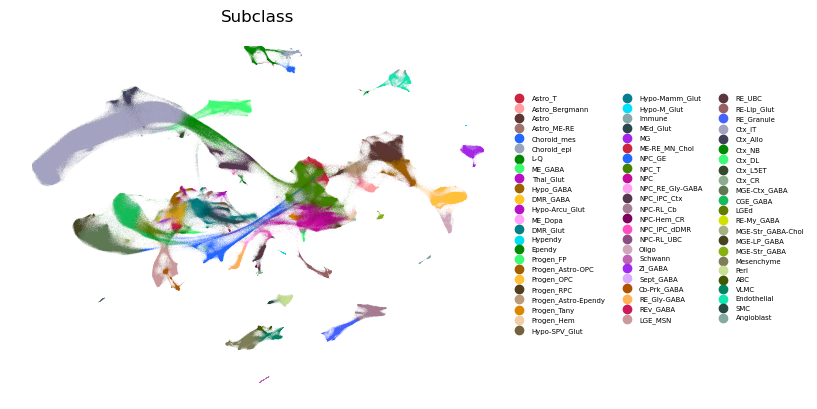

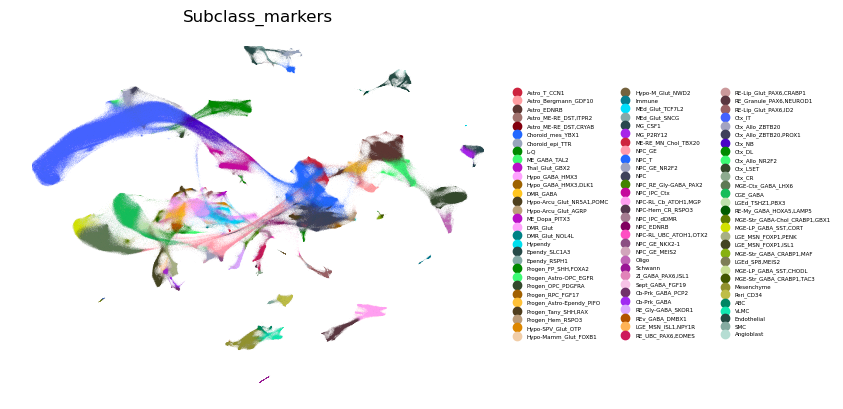

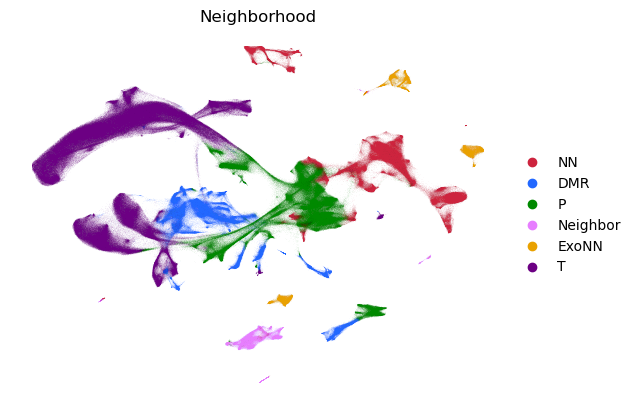

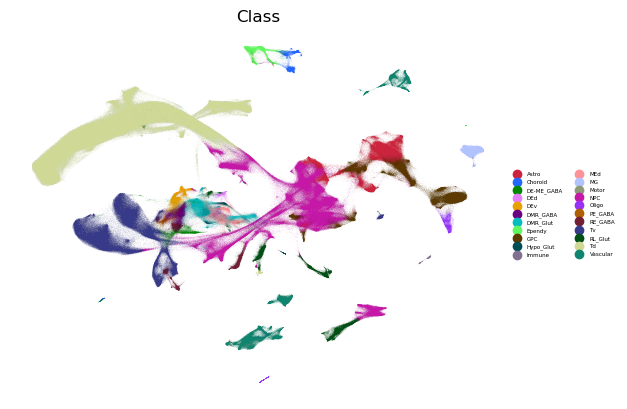

In [95]:
embed_configs = [
    (['Subclass'],                     dict(legend_fontsize=5, frameon=False)),
    (['Subclass_markers'],             dict(legend_fontsize=4, frameon=False)),
    (['Neighborhood'],                 dict(frameon=False)),
    (['Class'],                        dict(legend_fontsize=4, frameon=False)),
]
for cols, opts in embed_configs:
    sc.pl.embedding(
        adata, basis=MDE_KEY,
        color=cols,
        **opts
    )

In [30]:
# 6) Cluster parameters from model
pstore = adata.uns['param_store']
(
    discov_cp, cp, labels, var_labels, zm,
    (pt,_, di, dm)
) = model.calculate_cluster_params(flavor='numpy')

# keep only present clusters
keep = np.isin(labels, adata.obs[leaf_key].cat.categories.astype(int))
labels = np.array(labels)[keep]
zm     = zm[:,keep,:]
idx    = labels.astype(int)

# apply mask
discov_cp = np.nan_to_num(discov_cp[:,idx,:],posinf=np.nan)*zm
pt        = pt[idx,:]
di        = di[:,idx,:]*zm
dm        = dm[:,idx,:]*zm

prop_locs_dynam = np.einsum('pc,cm->pm', 
                           pt, 
                           pstore['locs_dynam'])

prop_locs = np.einsum('pc,cm->pm', 
                           pt, 
                           pstore['locs'])

# take log of the sum of absolute values per cluster
dynam_var = np.log(np.abs(prop_locs_dynam).sum(axis=1))

# map back to each cell’s level_2 label
dynam_dict = {i: dynam_var[i] for i in range(len(dynam_var))}
adata.obs['log_abs_sum_dynam'] = (
    adata.obs[leaf_key]
        .astype(int)
        .map(dynam_dict)
)

cluster_idx    = adata.obs[leaf_key].cat.categories.astype(int).tolist()

# 2) make string labels for each latent dimension
latent_labels  = [str(i) for i in range(pstore['locs'].shape[1])]

# 3) DataFrame of propagated locations
loc_df = pd.DataFrame(
    prop_locs,
    index=cluster_idx,
    columns=latent_labels
)

# 4) “Raw” locs (before propagation)
leaf_loc_df = pd.DataFrame(
    pstore['locs'][cluster_idx, :],
    index=cluster_idx,
    columns=latent_labels
)

# 5) add tiny noise for numerical stability
loc_df += np.random.standard_normal(loc_df.shape) * 1e-10

# 6) set the index name so dendrogram code picks it up
loc_df.index.name      = leaf_key
leaf_loc_df.index.name = leaf_key


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:450: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zero_mask = (adata.obs.groupby(self.discov_key)[leaf_level].value_counts().unstack().loc[:,cluster_labels]>=cluster_count_threshold).to_numpy()
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:451: RuntimeWarning: divide by zero encountered in divide
  return discov_cluster_params,cluster_params, cluster_labels,var_labels, 1/zero_mask[...,np.newaxis],(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)


In [31]:
# %%
# 7) Basic obs cleanup & colors
adata.obs['region'] = adata.obs['region'].astype('category')
adata.uns['region_colors']         = [
    adata.uns['region_colors_dict'][c] for c in adata.obs['region'].cat.categories
]
adata.uns['general_region_colors'] = [
    adata.uns['general_region_color_dict'][c] for c in adata.obs['general_region'].cat.categories
]
adata.uns['species_colors']        = [
    adata.uns['species_color_dict'][c] for c in adata.obs[discov_key].cat.categories
]

# inferred sex
sexmap = pd.read_csv(
    f'{annotation_path}/inferred_sex.csv', index_col=0
)['female'].to_dict()
adata.obs['female'] = adata.obs['batch_name'].map(sexmap)

# %%
# 9) Drop old hvg/neighbors & merge any missing obs
for k in ['hvg','neighbors']:
    adata.uns.pop(k, None)
extra = set(data_uns.obs.columns) - set(adata.obs.columns)
adata.obs[list(extra)] = data_uns.obs[list(extra)]

# decode full_cellname
adata.obs['full_cellname'] = (
    adata.obs['full_cellname'].str.decode('utf-8').astype(str)
)

In [37]:
for x in ['Class','Subclass','Subclass_markers','level_2','level_1','Neighborhood']:
    adata.obs[x] = adata.obs[x].astype('category')

In [35]:
# adata.obs.loc[:,["Neighborhood","Class","Subclass","Subclass_markers","core_markers"]].to_csv(f'{annotation_path}/clustermeta1_to_cell_annotations.tsv',sep='\t')

In [ ]:
# 10) Register phase & other colormaps
adata.uns['phase_color_dict'] = {'G1':'teal','G2M':'lightcoral','S':'gold'}
adata.uns['phase_colors']     = [
    adata.uns['phase_color_dict'][p] for p in adata.obs['phase'].cat.categories
]

cmap_defs = {
    'phase_pal':          adata.uns['phase_colors'],
    'godsnot_102':        sc.pl.palettes.godsnot_102,
    'godsnot_big':        sc.pl.palettes.godsnot_102 * 3,
    'bog':                list(adata.uns['species_color_dict'].values()),
}
for name, cols in cmap_defs.items():
    cmap = matplotlib.colors.ListedColormap(cols, name=name)
    try:    matplotlib.colormaps.register(name=name, cmap=cmap)
    except: pass

# ensure categories
adata.obs['level_1'] = adata.obs['level_1'].astype(int).astype('category')
adata.obs['level_2'] = adata.obs['level_2'].astype(int).astype('category')

# # %%
# # 12) Generate and register palettes
hier1 = antipode.plotting.create_hierarchical_palette(
    adata,
    ['Class','Subclass','Subclass_markers','level_2','level_1'],
    glasbey.create_palette,
    grid_size=128, grid_space="RGB",
    lightness_bounds=(20,80), chroma_bounds=(20,80),
    colorblind_safe=False, as_hex=True,
    hue_cushion=0.05
)

hier2 = antipode.plotting.create_hierarchical_palette(
    adata,
    ['Neighborhood'],
    glasbey.create_palette,
    grid_size=128, grid_space="RGB",
    lightness_bounds=(20,80), chroma_bounds=(20,80),
    colorblind_safe=False, as_hex=True,
    hue_cushion=0.05
)



In [39]:
pstore = adata.uns['param_store']
discov_cluster_params,cluster_params, cluster_labels,var_labels, zero_mask,(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)=model.calculate_cluster_params(flavor='numpy')
keep_clusters = np.array([x in adata.obs['level_2'].unique() for x in cluster_labels ])
cluster_labels = np.array(cluster_labels)[keep_clusters]
zero_mask = zero_mask[:,keep_clusters,:]
cluster_index = np.array([int(x) for x in cluster_labels])
zero_mask = np.nan_to_num(zero_mask,posinf=np.nan)
discov_cluster_params = discov_cluster_params[:,cluster_index,:] * zero_mask
prop_locs = prop_locs[cluster_index,:]
prop_discov_di = prop_discov_di[:,cluster_index,:] * zero_mask
prop_discov_dm = prop_discov_dm[:,cluster_index,:] * zero_mask
discov_labels=adata.obs[model.discov_key].cat.categories
latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
n_clusters=model.level_sizes[-1]


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:450: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zero_mask = (adata.obs.groupby(self.discov_key)[leaf_level].value_counts().unstack().loc[:,cluster_labels]>=cluster_count_threshold).to_numpy()
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:451: RuntimeWarning: divide by zero encountered in divide
  return discov_cluster_params,cluster_params, cluster_labels,var_labels, 1/zero_mask[...,np.newaxis],(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)


In [40]:
zdw_df = pd.DataFrame(pstore['z_decoder_weight'],columns = var_labels).T

In [41]:
leaf_key = 'level_2'

In [44]:
adata.obs['subclass_markers_level_2'] = adata.obs['Subclass_markers'].astype(str) + '_' + adata.obs['level_2'].astype(str)
adata.obs['subclass_markers_level_2'] = adata.obs['subclass_markers_level_2'].astype('category')
sc.tl.dendrogram(adata,groupby='subclass_markers_level_2',use_rep='X_antipode',linkage_method='average',cor_method='kendall')
adata.obs['subclass_markers_level_2'] = adata.obs['subclass_markers_level_2'].cat.reorder_categories(adata.uns['dendrogram_'+'subclass_markers_level_2']['categories_ordered'])
sc.tl.dendrogram(adata,groupby='level_2',use_rep='X_antipode',linkage_method='average',cor_method='kendall')
adata.obs['level_2'] = adata.obs['level_2'].cat.reorder_categories(adata.uns['dendrogram_'+'level_2']['categories_ordered'])

with plt.rc_context({'font.size': 6}):
    fig, axs = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=(4,30),
    )
    sc.pl.dendrogram(adata,groupby='subclass_markers_level_2',ax=axs,orientation='left')

leaf_l2_dict = dict(zip(adata.obs['subclass_markers_level_2'].cat.categories,adata.obs['level_2'].cat.categories))
l2_leaf_dict = dict(zip(adata.obs['level_2'].cat.categories,adata.obs['subclass_markers_level_2'].cat.categories))
# leaf_labels = [l2_leaf_dict[x] for x in cluster_labels]


KeyboardInterrupt



In [45]:
adata.uns['level_2_colors'] = [adata.uns['level_2_colors_dict'][x] for x in adata.obs['level_2'].cat.categories]
adata.uns['subclass_markers_level_2_colors'] = [adata.uns['level_2_colors_dict'][leaf_l2_dict[x]] for x in adata.obs['subclass_markers_level_2'].cat.categories]
adata.uns['subclass_markers_level_2_colors_dict'] = dict(zip(adata.obs['subclass_markers_level_2'].cat.categories,adata.uns['subclass_markers_level_2_colors']))

KeyError: 'ABC_100'

In [46]:
adata.obs['clipped_psi_2'] = np.clip(adata.obs['psi_2'],np.quantile(adata.obs['psi_2'] ,0.1),np.quantile(adata.obs['psi_2'] ,0.9))

In [49]:
adata.obsm[MDE_KEY] = np.loadtxt("/home/matthew.schmitz/Matthew/models/1.9.1.8.5_Dev_final_looser/X_umap.csv", delimiter=",")


ERROR! Session/line number was not unique in database. History logging moved to new session 225


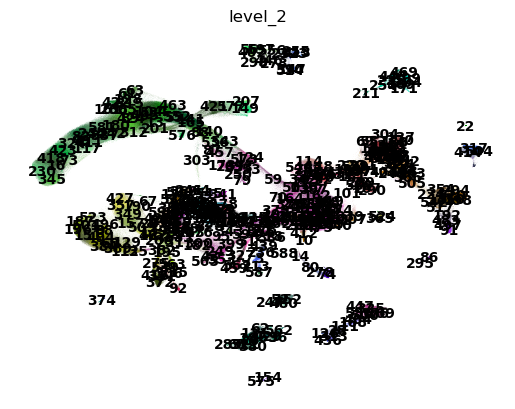

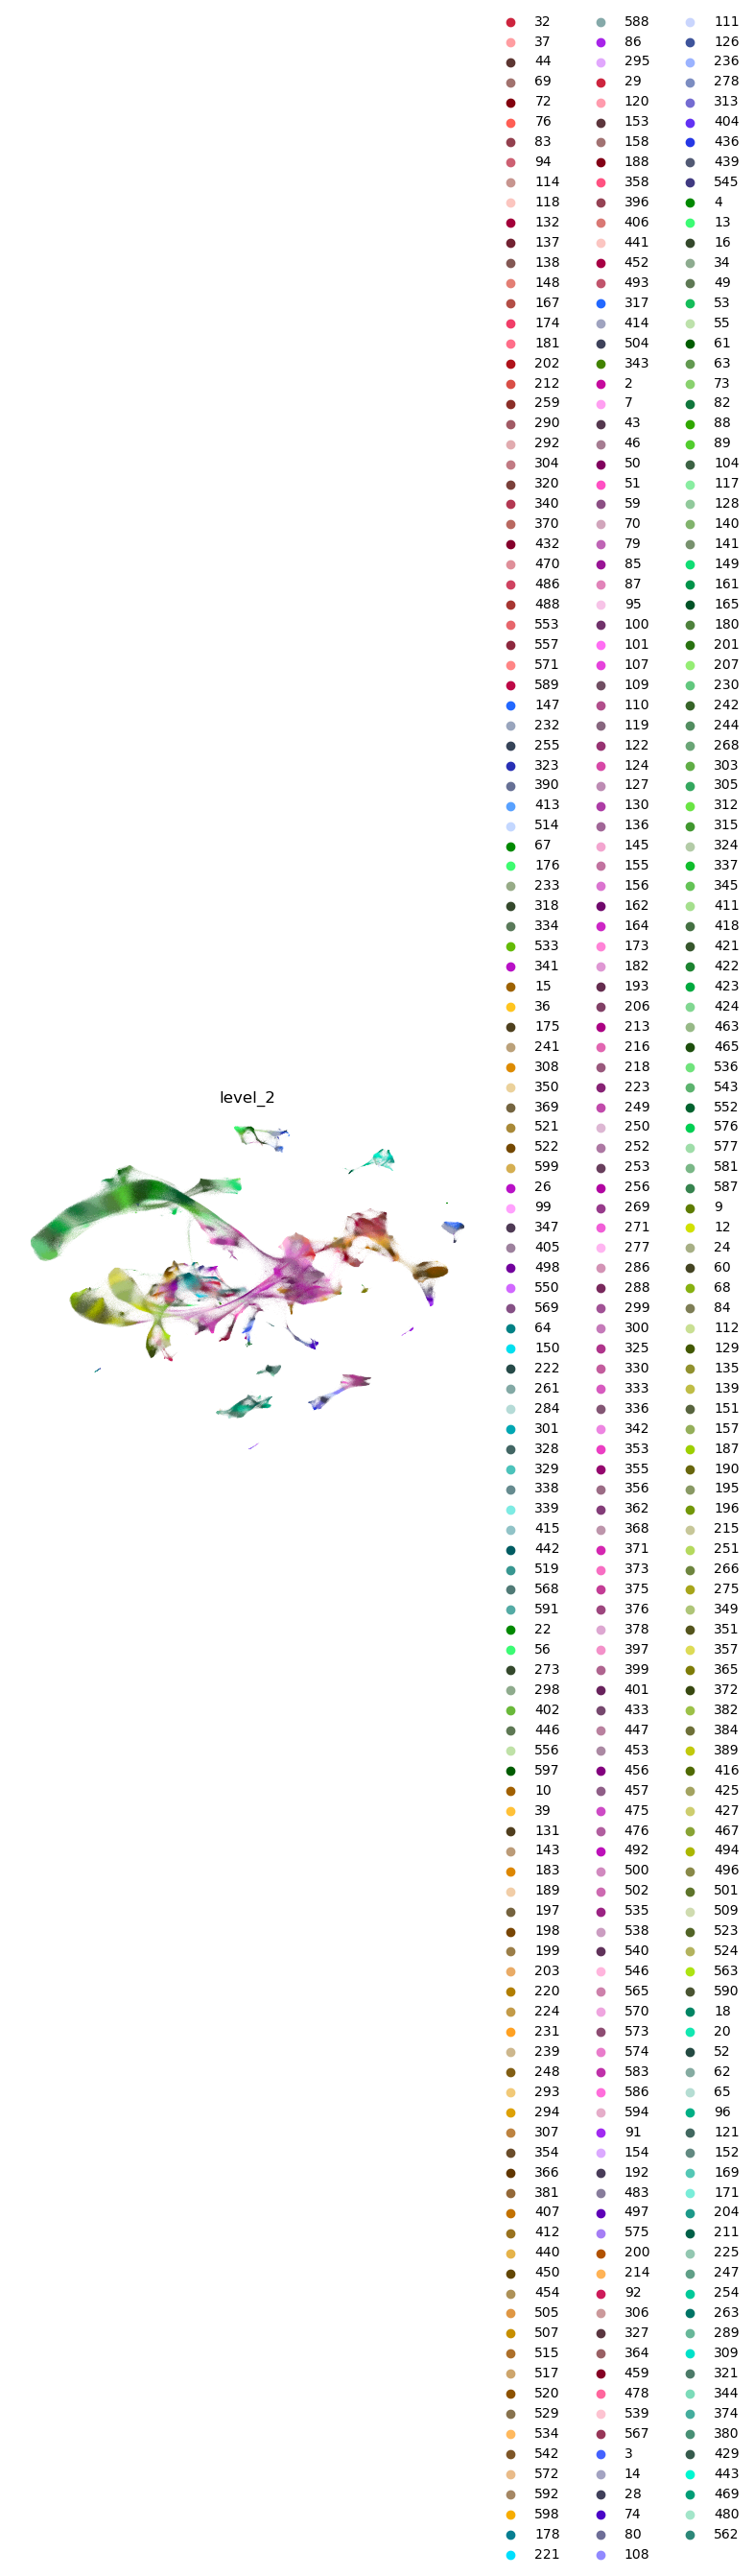


KeyboardInterrupt



In [50]:
# 13) Embedding plots (looped)
embed_configs = [
    (['level_2'],                      dict(legend_loc='on data', frameon=False)),
    (['level_2'],                      dict(frameon=False)),
    (['subclass_markers_level_2'],                      dict(frameon=False)),
    (['Subclass'],                     dict(legend_loc='on data',legend_fontsize=5, frameon=False)),
    (['Subclass_markers'],             dict(legend_loc='on data',legend_fontsize=4, frameon=False)),
    (['Neighborhood'],                 dict(frameon=False)),
    (['Class'],                        dict(legend_loc='on data',legend_fontsize=4, frameon=False)),
    ([batch_key],                      dict(palette=sc.pl.palettes.godsnot_102, frameon=False)),
    ([discov_key],                    dict(palette='bog', frameon=False)),
    (['abc_subclass_markercor'],      dict(palette=sc.pl.palettes.godsnot_102,frameon=False)),
    (['region'],                      dict(frameon=False)),
    (['general_region'],              dict(frameon=False)),
    (['log_abs_sum_dynam'],           dict(cmap='coolwarm', frameon=False)),
    (['psi_1'],           dict(cmap='coolwarm',frameon=False)),
    (['clipped_psi_2'],           dict(cmap='coolwarm', frameon=False)),
    (['level_1'],                      dict(legend_loc='on data', frameon=False)),
]
for cols, opts in embed_configs:
    sc.pl.embedding(
        adata, basis=MDE_KEY,
        color=cols,
        **opts
    )

In [52]:
adata.uns['level_1_colors_dict'] = {str(k):v for k,v in adata.uns['level_1_colors_dict'].items()}
adata.uns['level_2_colors_dict'] = {str(k):v for k,v in adata.uns['level_2_colors_dict'].items()}
adata.uns[f'{'subclass_markers_level_2'}_colors_dict'] = {str(k):v for k,v in adata.uns[f'{'subclass_markers_level_2'}_colors_dict'].items()}

In [55]:
anndata.settings.allow_write_nullable_strings = True
adata.obs['female'] = adata.obs['female'].astype(str)
cols = ['phase',discov_key,'region','general_region','level_1',leaf_key,'clipped_psi_2','timepoint','species_dataset_name','log10_n_counts','Neighborhood','Subclass','','Class','Subclass_markers','abc_subclass_markercor','juv_subclass_markercor']
adata.obs = adata.obs.loc[:,[x for x in cols if x in adata.obs.columns]]
adata.obs = adata.obs.loc[:,~adata.obs.columns.duplicated()]
adata.obs['Subclass'] = [str(x) for x in adata.obs['Subclass']]
del adata.layers[layer_key]
del adata.obsm['discov_onehot']
del adata.obsm['kmeans_onehot']
del adata.obsm['phase_sex']
del adata.obsm['taxon_probs']
adata.obs['Subclass'] = adata.obs['Subclass'].astype(str)
anndata.settings.allow_write_nullable_strings = False
adata.write(model_path/'check600_cellxgene.h5ad')
get_ipython().system(
    f'cp {model_path}/check600_cellxgene.h5ad '
    '/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/V1Evo/'
)


In [ ]:
# %%
# 16) Heatmaps for subclass vs cluster matching
for key in ['Subclass_markers','abc_subclass_markercor']:
    mat = adata.obs.groupby('subclass_markers_level_2')[key].value_counts(normalize=True).unstack().T
    diag = sc_analysis.maximize_diagonality(mat.values)
    df   = pd.DataFrame(diag[0], index=mat.index, columns=mat.columns[diag[2]])
    sc_analysis.create_heatmap(df)
    plt.xticks(rotation=270)
    plt.show()

In [19]:
# sc.pl.dotplot(
#     adata,
#     groupby='level_2',
#     var_names=['GAD2','SLC17A6']
# )


In [20]:
# # sc.tl.dendrogram(adata,groupby='level_2',linkage_method='ward',use_rep='X_antipode')
# # row_linkage = adata.uns[f'dendrogram_{leaf_key}']['linkage']
# # cluster_order = adata.uns[f'dendrogram_{leaf_key}']['categories_idx_ordered']

# row_linkage = scipy.cluster.hierarchy.linkage(loc_df, method='ward')
# cluster_order = scipy.cluster.hierarchy.leaves_list(row_linkage)

# col_linkage = scipy.cluster.hierarchy.linkage(loc_df.abs().T, method='average', metric='correlation')
# latent_order = scipy.cluster.hierarchy.leaves_list(col_linkage)

# # %%
# # 18) Variance dataframes
# dc_df  = pd.DataFrame(pstore['discov_dc'].var(2).T, index=list(map(str,range(pstore['discov_dc'].shape[1]))), columns=adata.uns['species_color_dict'].keys())
# dm_df  = pd.DataFrame(dm.var(2).T, index=labels, columns=adata.obs[discov_key].cat.categories)
# dmt_df = pd.DataFrame(dm.var(1).T, index=list(map(str,range(dm.shape[2]))), columns=adata.obs[discov_key].cat.categories)
# di_df  = pd.DataFrame(di.var(2).T, index=labels, columns=adata.obs[discov_key].cat.categories)

# # reorder adata.obs for leaf_key
# adata.obs[leaf_key] = adata.obs[leaf_key].cat.reorder_categories(sorted(adata.obs[leaf_key].cat.categories))

# n_gene_counts = (adata.layers[layer_key] > 0).sum(axis=1).A1
# adata.obs['log_n_genes'] = np.log10(n_gene_counts)

# # 2) group by leaf_key and aggregate
# cluster_anno = (
#     adata.obs
#          .groupby(leaf_key)
#          .agg({
#              'level_1'    : lambda x: x.value_counts().idxmax(),
#              'log_n_genes': 'mean',
#              'phase'      : lambda x: x.value_counts().idxmax(),
#              'Subclass'   : lambda x: x.value_counts().idxmax(),
#              'Class'      : lambda x: x.value_counts().idxmax(),
#          })
# )

# # 3) ensure the index is in category‐sorted order
# cluster_order = sorted(adata.obs[leaf_key].cat.categories)
# cluster_anno   = cluster_anno.reindex(cluster_order)

# # 4) now build your left_ha exactly as before
# left_ha = pch.HeatmapAnnotation(
#     Class       = pch.anno_simple(cluster_anno['Class'],       cmap='Class_pal',    legend=True),
#     Subclass    = pch.anno_simple(cluster_anno['Subclass'],    cmap='Subclass_pal'),
#     level_1     = pch.anno_simple(cluster_anno['level_1'],     cmap='level_1_pal'),
#     phase       = pch.anno_simple(cluster_anno['phase'],       cmap='phase_pal',    legend=True),
#     log_n_genes = pch.anno_simple(cluster_anno['log_n_genes'], cmap='Blues'),
#     axis=0
# )

# # %%
# # 20) Species & region annotations
# cell_cut = 50
# spec_mat = adata.obs.groupby(leaf_key)[discov_key].value_counts().unstack()
# spec_frac= spec_mat.div(spec_mat.sum(0),axis=1)
# spec_bin = spec_mat>cell_cut

# ha_dict = {}
# # region
# reg_mat = adata.obs.groupby(leaf_key)['general_region'].value_counts(normalize=True).unstack()
# for col in reg_mat:
#     ha_dict[col] = pch.anno_simple(reg_mat[col], cmap='Greens')
# # species fraction & binary
# for col in spec_frac:
#     ha_dict[f"{col} frac"] = pch.anno_simple(spec_frac[col], cmap='Blues')
#     ha_dict[f"{col}>{cell_cut}"] = pch.anno_simple(spec_bin[col], cmap='Grays')
# # DM & DI
# for col in dm_df:
#     ha_dict[f"{col}_DM"] = pch.anno_simple(dm_df[col], cmap='Purples')
#     ha_dict[f"{col}_DI"] = pch.anno_simple(di_df[col], cmap='Reds')

# ha_dict['label'] = pch.anno_label(pd.DataFrame(cluster_anno.index)['level_2'], merge=True, rotation=0, adjust_color=False)

# right_ha = pch.HeatmapAnnotation(**ha_dict, axis=0)

# # %%
# # 21) Gene‐set prereank & clustermap
# div_markers={'G0':list(set([])),#'YWHAG','NNAT'
#              'G1':list(set(['CCND1','CCND2','CCND3','CCNE1','CCNE2','MKI67','PCNA'])),
# 'G1S':list(set(['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7',
#       'DTL', 'PRIM1', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'RAD51AP1', 'GMNN', 
#       'WDR76', 'SLBP', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 
#       'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 
#       'E2F8','H4C3','H1-3','H1-5','H2AC12','H2AC20','H1-2','H1-4','H1-1','FBXO5',
#       'SPC25','FAM83D','HIST1H1A','HIST1H1B','HIST1H1C','HIST1H1D','HIST1H1E','CCND1','CCND2','CCND3'])),#,'CCNE1', 'CCNE2'
# 'G2M':list(set(['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2', 
#        'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 
#        'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'HN1', 
#        'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 
#        'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3', 
#        'GAS2L3', 'CBX5','ASPM','CENPA','CCND1','CCND2','CCND3']))
#         }

# short_lists = {
#     'G1/S':div_markers['G1S'],
#     'G2/M':div_markers['G2M'],
#     'SFARI Autism':pd.read_csv(f'{gl_path}/SFARI_autism.tsv',sep='\t').query('`gene-score`>2')['gene-symbol'],
#     'TFs': pd.read_csv(f'{gl_path}/TFs_lambert_pmid29425488_1.01.txt',sep='\t')['hgnc_symbol']
# }
# # filter small
# short_lists = {k:v for k,v in short_lists.items() if adata.var_names.isin(v).sum()>=5}

# # prerank
# zdw = pd.DataFrame(np.abs(pstore['z_decoder_weight']).T, index=adata.var_names)
# pr_out = get_prerank_from_mat(zdw, short_lists, min_size=3, max_size=500, permutation_num=1000)
# pr_df  = pr_out.pivot_table(index='input_column', columns='Term', values='NES')
# pr_pv  = pr_out.pivot_table(index='input_column', columns='Term', values='FDR q-val')

# seaborn.clustermap(pr_df.astype(float).T, cmap='coolwarm', metric='correlation')

# # 22) Final cluster map combining loc_df & annotations
# scaled = (loc_df - loc_df.mean()) / (loc_df.std().quantile(0.25) + loc_df.std())
# mval   = np.max(np.abs([scaled.min().min(), scaled.max().max()]))*0.5

# fig = plt.figure(figsize=(10,8))
# pch.ClusterMapPlotter(
#     data         = scaled,
#     cmap         = 'coolwarm',
#     row_cluster  = True,
#     row_dendrogram_kws = {'linkage':row_linkage},
#     col_cluster  = True,
#     col_dendrogram_kws = {'linkage':col_linkage},
#     left_annotation  = left_ha,
#     right_annotation = right_ha,
#     rasterized   = False
# )
# plt.savefig(sc.settings.figdir/'Fig2Clustermap.pdf')
# plt.show()

In [21]:
# sc.tl.dendrogram(adata,groupby=subclass_key,use_rep='X_antipode',linkage_method='average',cor_method='spearman')
# sc.pl.dendrogram(adata,groupby=subclass_key)

# sc.tl.dendrogram(adata,groupby=neighborhood_key,use_rep='X_antipode',linkage_method='average',cor_method='spearman')
# sc.pl.dendrogram(adata,groupby=neighborhood_key)

# sc.tl.dendrogram(adata,groupby=leaf_key,use_rep='X_antipode',linkage_method='average',cor_method='spearman')
# sc.pl.dendrogram(adata,groupby=leaf_key)



In [22]:
row_linkage = adata.uns[f'dendrogram_{leaf_key}']['linkage']
cluster_order = adata.uns[f'dendrogram_{leaf_key}']['categories_ordered']
inv_order = np.argsort(adata.uns[f'dendrogram_{leaf_key}']['categories_idx_ordered'])

In [23]:
# row_linkage = scipy.cluster.hierarchy.linkage(loc_df, method='average')
# cluster_order = scipy.cluster.hierarchy.leaves_list(row_linkage)

for lvl in ['Neighborhood','Class','Subclass','Subclass_markers','level_1','level_2']:
    cols = [adata.uns[f"{lvl}_colors_dict"][x] for x in adata.obs[lvl].cat.categories]
    cmap = matplotlib.colors.ListedColormap(cols,name=f"{lvl}_pal")
    try:    matplotlib.colormaps.unregister(name=f"{lvl}_pal",cmap=cmap)
    except: pass
    try:    matplotlib.colormaps.register(name=f"{lvl}_pal",cmap=cmap)
    except: pass

cluster_labels = cluster_order
discov_labels = adata.obs[discov_key].cat.categories
dc_df=pd.DataFrame(pstore['discov_dc'].var(2).T,index=latent_labels,columns=discov_labels)
prop_di=np.einsum('lc,scg->slg',pt,pstore['discov_di'])
prop_dm=np.einsum('lc,scg->slg',pt,pstore['discov_dm'])
dm_df=pd.DataFrame(prop_dm.var(2).T,index=cluster_labels,columns=discov_labels)
dmt_df=pd.DataFrame((prop_dm.var(1)).T,index=latent_labels,columns=discov_labels)
di_df=pd.DataFrame(prop_di.var(2).T,index=cluster_labels,columns=discov_labels)
adata.obs[leaf_key] = adata.obs[leaf_key].cat.reorder_categories(adata.obs[leaf_key].cat.categories)

In [43]:
cluster_anno_df=pd.DataFrame(adata.obs.groupby(leaf_key)['level_1'].value_counts(dropna=True).unstack().idxmax(1))
cluster_anno_df.columns=['level_1']
cluster_anno_df[leaf_key]=adata.obs[leaf_key].cat.categories
adata.obs['log_n_genes'] = np.log10((adata.layers[layer_key]>0).sum(1).A1)
cluster_anno_df['log_n_genes']=adata.obs.groupby(leaf_key)['log_n_genes'].mean()
cluster_anno_df['phase']=adata.obs.groupby(leaf_key)['phase'].value_counts(dropna=True).unstack().idxmax(1)
cluster_anno_df['Subclass']=adata.obs.groupby(leaf_key)['Subclass'].value_counts(dropna=True).unstack().idxmax(1)
cluster_anno_df['Class']=adata.obs.groupby(leaf_key)['Class'].value_counts(dropna=True).unstack().idxmax(1)
cluster_anno_df['Class']=cluster_anno_df['Class'].astype('category')
cluster_anno_df['Class']=cluster_anno_df['Class'].cat.reorder_categories(adata.obs['Class'].cat.categories)
cluster_anno_df['level_1']=cluster_anno_df['level_1'].astype(str)

cluster_anno_df['Subclass']=cluster_anno_df['Subclass'].astype('category')
cluster_anno_df['Subclass']=cluster_anno_df['Subclass'].cat.reorder_categories(adata.obs['Subclass'].cat.categories)
cluster_anno_df.index=list(cluster_anno_df[leaf_key])


left_ha = pch.HeatmapAnnotation(
            Class=pch.anno_simple(cluster_anno_df.Class,colors=[adata.uns['Class_colors_dict'][x] for x in cluster_anno_df.Class.unique()], rasterized=False,legend=True),#,cmap='Class_pal'),
            Subclass=pch.anno_simple(cluster_anno_df.Subclass, rasterized=False,legend=False,colors=[adata.uns['Subclass_colors_dict'][x] for x in cluster_anno_df.Subclass.unique()]),
            level_1=pch.anno_simple(cluster_anno_df.level_1, rasterized=False,legend=False,colors=[adata.uns['level_1_colors_dict'][x] for x in cluster_anno_df.level_1.unique()]),
            phase=pch.anno_simple(cluster_anno_df['phase'], rasterized=False,colors=[adata.uns['phase_color_dict'][x] for x in cluster_anno_df.phase.unique()],legend=True),#
            log_n_genes=pch.anno_simple(cluster_anno_df.log_n_genes, rasterized=False,legend=False,cmap='Blues'),
            axis=0)

In [25]:
cell_cutoff=50
species_binary=adata.obs.groupby(leaf_key)[discov_key].value_counts(normalize=False).unstack()>cell_cutoff
zdw_mat=pd.DataFrame(np.absolute(pstore['z_decoder_weight']),index=latent_labels,columns=var_labels).T
species_mat=adata.obs.groupby(leaf_key)[discov_key].value_counts(normalize=False).unstack()
species_mat=(species_mat/species_mat.sum(0))
region_mat=adata.obs.groupby(leaf_key)['general_region'].value_counts(normalize=True).unstack()
region_mat=region_mat.loc[:,['ctx','ge','bn','de','mb','hb','cp','h']]

species_ha_dict={}
for col in region_mat.columns:
    species_ha_dict[col]=pch.anno_simple(region_mat[col],cmap='Greens',legend=False)

for col in species_mat.columns:
    species_ha_dict[col+' cell#']=pch.anno_simple(species_mat[col],cmap='Blues',legend=False)

for col in species_binary.columns:
    species_ha_dict[col+'>'+str(cell_cutoff)]=pch.anno_simple(species_binary[col],cmap='Grays',legend=False)

for col in dm_df.columns:
    species_ha_dict[col+'_DM']=pch.anno_simple(dm_df[col],cmap='Purples',legend=False)

for col in di_df.columns:
    species_ha_dict[col+'_DI']=pch.anno_simple(di_df[col],cmap='Reds',legend=False)

species_ha_dict['label']=pch.anno_label(cluster_anno_df[leaf_key], merge=True, rotation=0,adjust_color=False,colors='black',extend=True,relpos=[-6.,0.],fontsize=1.2,arrowprops = dict(visible=False))

right_ha = pch.HeatmapAnnotation(**species_ha_dict,axis=0)


/scratch/fast/1321852/ipykernel_25324/2392352650.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  species_binary=adata.obs.groupby(leaf_key)[discov_key].value_counts(normalize=False).unstack()>cell_cutoff
/scratch/fast/1321852/ipykernel_25324/2392352650.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  species_mat=adata.obs.groupby(leaf_key)[discov_key].value_counts(normalize=False).unstack()
/scratch/fast/1321852/ipykernel_25324/2392352650.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current beha

In [26]:
div_markers={'G0':list(set([])),#'YWHAG','NNAT'
             'G1':list(set(['CCND1','CCND2','CCND3','CCNE1','CCNE2','MKI67','PCNA'])),
'G1S':list(set(['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7',
      'DTL', 'PRIM1', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'RAD51AP1', 'GMNN', 
      'WDR76', 'SLBP', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 
      'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 
      'E2F8','H4C3','H1-3','H1-5','H2AC12','H2AC20','H1-2','H1-4','H1-1','FBXO5',
      'SPC25','FAM83D','HIST1H1A','HIST1H1B','HIST1H1C','HIST1H1D','HIST1H1E','CCND1','CCND2','CCND3'])),#,'CCNE1', 'CCNE2'
'G2M':list(set(['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2', 
       'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 
       'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'HN1', 
       'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 
       'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3', 
       'GAS2L3', 'CBX5','ASPM','CENPA','CCND1','CCND2','CCND3']))
        }

gl_path='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/'
vg_genes=pd.read_csv(os.path.join(gl_path,'HGNC_voltage_gated.tsv'),sep='\t')
np_genes=pd.read_csv(os.path.join(gl_path,'MTS_neuropeptides_receptors.tsv'),sep='\t')
np_genes['type'] = np_genes['type'].str.split(',')
np_genes = np_genes.explode('type')
autism_genes=pd.read_csv(os.path.join(gl_path,'SFARI_autism.tsv'),sep='\t')
tf_genes=pd.read_csv(os.path.join(gl_path,'TFs_lambert_pmid29425488_1.01.txt'),sep='\t')

short_gene_lists={
    'G1/S':div_markers['G1S'],
    'G2/M':div_markers['G2M'],
    'TFs':tf_genes['hgnc_symbol'],
    'SFARI Autism':autism_genes.loc[autism_genes['gene-score']>2,'gene-symbol']
}

bp_dict=gseapy.get_library('GO_Biological_Process_2023')
bp_keys=list(bp_dict.keys())

chosen_bp=['Negative Regulation Of Heterochromatin Formation (GO:0031452)',
    'Positive Regulation Of Heterochromatin Formation (GO:0031453)',
'Mitochondrion Distribution (GO:0048311)',
 ]
bp=chosen_bp

for x in bp:
    term=x.split(' (GO:')[0]
    short_gene_lists[term]=bp_dict[x]

for k in short_gene_lists.keys():
    if adata.var.index.isin(short_gene_lists[k]).sum()<5:
        try:
            del gene_lists[k]
        except:
            pass


gene_lists={
    'G1/S':div_markers['G1S'],
    'G2/M':div_markers['G2M'],
    #'Voltage-gated':vg_genes['Approved symbol'],
    #'TFs':tf_genes['hgnc_symbol'],
    'SFARI Autism':autism_genes.loc[autism_genes['gene-score']>1,'gene-symbol'],
}




for k in short_gene_lists.keys():
    if adata.var.index.isin(short_gene_lists[k]).sum()<5:
        try:
            del gene_lists[k]
        except:
            pass


In [27]:
prerank_out=antipode.plotting.get_prerank_from_mat(zdw_mat,short_gene_lists,min_size=3,max_size=max([len(short_gene_lists[k]) for k in short_gene_lists.keys()])+100,permutation_num=5000)
prerank_out_df=prerank_out.pivot_table( index='input_column',columns='Term', values='NES', aggfunc='first').astype(float)
prerank_out_pval_df=prerank_out.pivot_table( index='input_column',columns='Term', values='FDR q-val', aggfunc='first').astype(float)

  0%|          | 0/200 [00:00<?, ?it/s]2025-06-14 23:13:58,946 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  0%|          | 1/200 [00:08<28:50,  8.70s/it]2025-06-14 23:14:07,548 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  2%|▏         | 4/200 [00:34<27:58,  8.56s/it]2025-06-14 23:14:33,191 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  2%|▎         | 5/200 [00:42<27:41,  8.52s/it]2025-06-14 23:14:41,639 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  3%|▎         | 6/200 [00:51<27:47,  8.59s/it]2025-06-14 23:14:50,373 [WARNING] Duplicated values found in preranked st

In [53]:
term_linkage=scipy.cluster.hierarchy.linkage(prerank_out_df.T,method='average',metric='correlation')
term_linkage_order_inds=scipy.cluster.hierarchy.leaves_list(term_linkage)
term_linkage_order=pd.Series(prerank_out_df.columns)[scipy.cluster.hierarchy.leaves_list(term_linkage)].to_list()

#cluster columns by abscorr
R = loc_df.corr(method='kendall').values#np.corrcoef(loc_df.T)        
# R = np.corrcoef(loc_df.T)            
D = 1 - np.abs(R)
col_linkage = scipy.cluster.hierarchy.linkage(D[np.triu_indices_from(D,1)], method="average")
latent_label_order_inds = scipy.cluster.hierarchy.leaves_list(col_linkage)
latent_label_order=pd.Series(latent_labels)[latent_label_order_inds].to_list()

In [84]:
fit_xs_scores = pd.read_csv('/home/matthew.schmitz/WbFigures/RegionalClocks/fit_xs_scores_scores.tsv',sep='\t',index_col=0)
fit_dt_scores = pd.read_csv('/home/matthew.schmitz/WbFigures/RegionalClocks/fit_dt_scores_scores.tsv',sep='\t',index_col=0)
fit_com_scores = pd.read_csv('/home/matthew.schmitz/WbFigures/RegionalClocks/fit_mu_scores_scores.tsv',sep='\t',index_col=0)

xs_corrs = []
for i in zdw_df.columns:
    xs_corrs.append(scipy.stats.spearmanr(zdw_df.loc[fit_xs_scores.index,i],fit_xs_scores).statistic)
xs_corrs = pd.Series(xs_corrs,index = zdw_df.columns.astype(str))

com_corrs = []
for i in zdw_df.columns:
    com_corrs.append(scipy.stats.spearmanr(zdw_df.loc[fit_com_scores.index,i],fit_com_scores).statistic)
com_corrs = pd.Series(com_corrs,index = zdw_df.columns.astype(str))

dt_corrs = []
for i in zdw_df.columns:
    dt_corrs.append(scipy.stats.spearmanr(zdw_df.loc[fit_dt_scores.index,i],fit_dt_scores).statistic)
dt_corrs = pd.Series(dt_corrs,index = zdw_df.columns.astype(str))


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


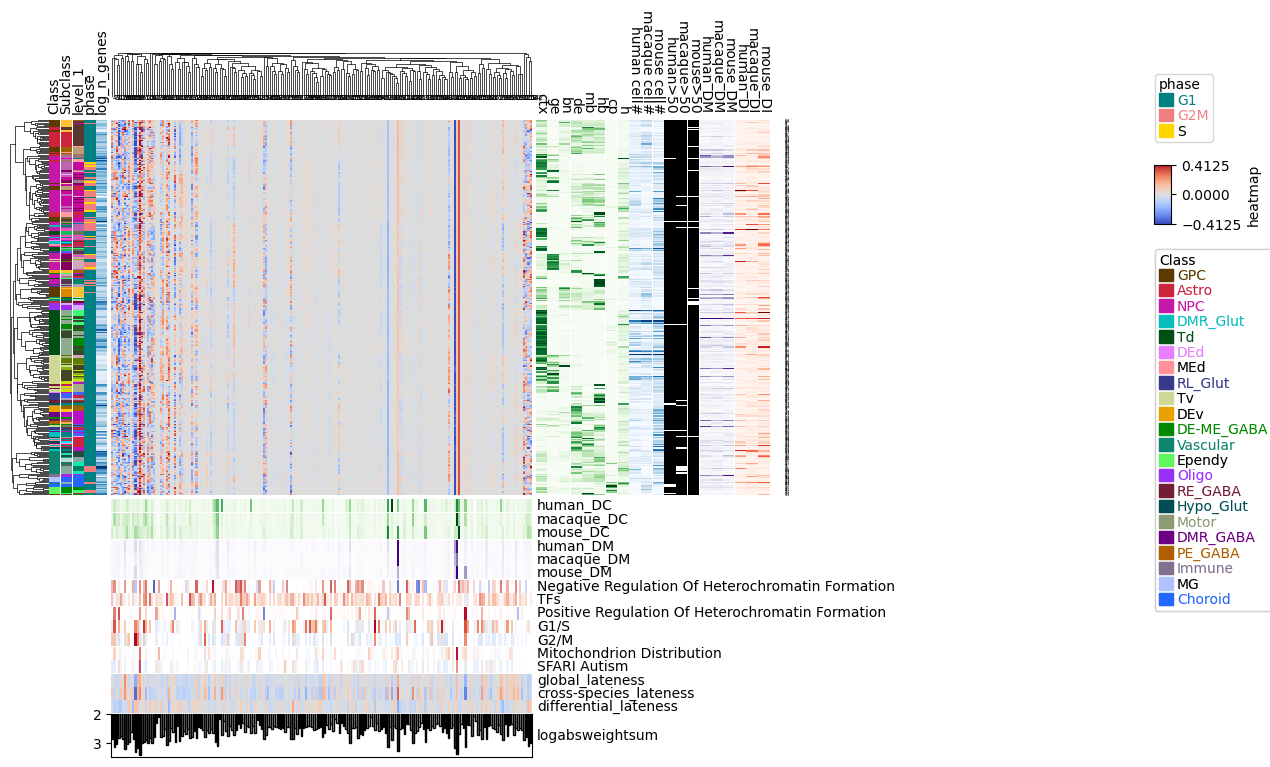

In [93]:
latent_ha_dict={}
breaks=pd.DataFrame({'breaks':[str(int(np.floor(i/20))) for i in range(len(latent_label_order))]},index=latent_label_order)

column_df=dc_df.copy()
column_df.loc[:,prerank_out_df.columns]=prerank_out_df
column_df.loc[:,breaks.columns]=breaks
column_df['index']=column_df.index
column_df=column_df.loc[latent_label_order,:]
column_df['xs_corrs'] = xs_corrs
column_df['com_corrs'] = com_corrs
column_df['dt_corrs'] = dt_corrs

for col in dc_df.columns:
    latent_ha_dict[col+'_DC']=pch.anno_simple(column_df[col],cmap='Greens',legend=False,rasterized=True)

for col in dmt_df.columns:
    latent_ha_dict[col+'_DM']=pch.anno_simple(dmt_df[col],cmap='Purples',legend=False,rasterized=True)

for k in term_linkage_order:#gl_preranks.keys():
    latent_ha_dict[k]=pch.anno_simple(column_df[k],cmap='coolwarm',legend=False,alpha=(1-prerank_out_pval_df.loc[column_df.index,k]))#vmin=prerank_out_df[k].min(),vmax=column_df[k].max(),

latent_ha_dict['global_lateness']=pch.anno_simple(column_df['xs_corrs'],cmap='coolwarm',legend=False,center=0.,vmin=-0.5,vmax=0.5)
latent_ha_dict['cross-species_lateness']=pch.anno_simple(column_df['com_corrs'],cmap='coolwarm',legend=False,center=0.,vmin=-0.5,vmax=0.5)
latent_ha_dict['differential_lateness']=pch.anno_simple(column_df['dt_corrs'],cmap='coolwarm',legend=False,center=0.,vmin=-0.5,vmax=0.5)

#latent_ha_dict['breaks']=pch.anno_simple(column_df['breaks'])

mat_anno_df=pd.DataFrame(np.log10(1.+np.absolute(pstore['z_decoder_weight']).sum(1)),columns=['logabsweightsum'],index=latent_labels)
column_df['logabsweightsum']=mat_anno_df
latent_ha_dict['logabsweightsum']=pch.anno_barplot(mat_anno_df['logabsweightsum'], cmap='Greys',rasterized=True,legend=False)
bottom_ha = pch.HeatmapAnnotation(**latent_ha_dict,axis=1,orientation='down',plot=False)


top_anno_dict={}
top_anno_dict['label']=pch.anno_label(column_df['index'], merge=True, rotation=0,adjust_color=False,colors='black',extend=True,relpos=[-1.,-5.],fontsize=5,arrowprops = dict(visible=False))
top_anno = pch.HeatmapAnnotation(**top_anno_dict,axis=1,orientation='up',plot=False)


plt.figure(figsize=(10,8))
scaleddf = loc_df.loc[cluster_order].iloc[inv_order]
# scaleddf=((loc_df-loc_df.mean(0))/(np.quantile(loc_df.std(0),0.25)+loc_df.std(0)))
max_val=np.max(np.absolute(scaleddf.min(),scaleddf.max()))*0.5 #clip to 0.5 of max to make more visible
cm1 = pch.ClusterMapPlotter(data=scaleddf,cmap='coolwarm',row_cluster=True,row_dendrogram=True,row_dendrogram_kws={'linkage':row_linkage},left_annotation=left_ha,top_annotation=top_anno,right_annotation=right_ha,bottom_annotation=bottom_ha,col_cluster=True,col_dendrogram=True,col_dendrogram_kws={'linkage':col_linkage},rasterized=True,vmin=-max_val,vmax=max_val)#,col_dendrogram=True,col_dendrogram_kws={'linkage':col_linkage})
plt.savefig(os.path.join(sc.settings.figdir,'Fig2Clustermap.svg'))
plt.show()

In [30]:
adata.uns['level_1_colors_dict'] = {str(k):v for k,v in adata.uns['level_1_colors_dict'].items()}
adata.uns['level_2_colors_dict'] = {str(k):v for k,v in adata.uns['level_2_colors_dict'].items()}
adata.uns[f'{'subclass_markers_level_2'}_colors_dict'] = {str(k):v for k,v in adata.uns[f'{'subclass_markers_level_2'}_colors_dict'].items()}

In [ ]:
# 23) Final writes for downstream
anndata.settings.allow_write_nullable_strings = True
adata.obs['female'] = adata.obs['female'].astype(str)
adata.write_h5ad(model_path/'analysis_inprogress.h5ad')
adata.obs.to_csv(model_path/'obs.tsv', sep='\t')
cols = ['phase',discov_key,'region','general_region','level_1',leaf_key,'clipped_psi_2','timepoint','species_dataset_name','log10_n_counts','Neighborhood','Subclass','','Class','Subclass_markers','abc_subclass_markercor','juv_subclass_markercor']
adata.obs = adata.obs.loc[:,[x for x in cols if x in adata.obs.columns]]
adata.obs = adata.obs.loc[:,~adata.obs.columns.duplicated()]
adata.obs['Subclass'] = [str(x) for x in adata.obs['Subclass']]
del adata.layers[layer_key]
del adata.obsm['discov_onehot']
del adata.obsm['kmeans_onehot']
del adata.obsm['phase_sex']
del adata.obsm['taxon_probs']
adata.obs['Subclass'] = adata.obs['Subclass'].astype(str)
anndata.settings.allow_write_nullable_strings = False
adata.write(model_path/'for_cellxgene.h5ad')
get_ipython().system(
    f'cp {model_path}/for_cellxgene.h5ad '
    '/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/V1Evo/'
)


In [ ]:
#print(gseapy.prerank(pd.DataFrame(zdw_mat.var(1)),'GO_Biological_Process_2023',min_size=10,max_size=1000,permutation_num=1000).res2d['Term'])
column_preranks={}
for x in tqdm.tqdm(zdw_mat.columns):
    if not x in column_preranks.keys():
        column_preranks[x]=gseapy.prerank(pd.DataFrame(zdw_mat)[x],'GO_Biological_Process_2023',min_size=25,max_size=500,permutation_num=100).res2d


In [ ]:
for k in column_preranks.keys():
    column_preranks[k]['module']=k

column_prerank_mat=pd.concat(column_preranks.values(),axis=0)
prerank_pval_mat=column_prerank_mat.pivot_table( index='module',columns='Term', values='FDR q-val').astype(float)
column_prerank_mat=column_prerank_mat.pivot_table( index='module',columns='Term', values='NES').astype(float)

In [ ]:
term_ranks=antipode.plotting.select_features_by_ica((column_prerank_mat*(1-prerank_pval_mat)).to_numpy(),20,20)
column_prerank_mat.columns[term_ranks]

In [ ]:
#bp=bp+list(column_prerank_mat.std(0).sort_values().index[-10:])
bp=chosen_bp+list(column_prerank_mat.columns[term_ranks])


In [ ]:
short_gene_lists={
    'G1/S':div_markers['G1S'],
    'G2/M':div_markers['G2M'],
    'TFs':tf_genes['hgnc_symbol'],
    'SFARI Autism':autism_genes.loc[autism_genes['gene-score']>2,'gene-symbol']
}

bp_dict=gseapy.get_library('GO_Biological_Process_2023')
bp_keys=list(bp_dict.keys())

chosen_bp=['Negative Regulation Of Heterochromatin Formation (GO:0031452)',
    'Positive Regulation Of Heterochromatin Formation (GO:0031453)',
'Mitochondrion Distribution (GO:0048311)',
 ]

for x in bp:
    term=x.split(' (GO:')[0]
    short_gene_lists[term]=bp_dict[x]

for k in short_gene_lists.keys():
    if adata.var.index.isin(short_gene_lists[k]).sum()<5:
        del gene_lists[k]

prerank_out=get_prerank_from_mat(zdw_mat,short_gene_lists,min_size=3,max_size=max([len(short_gene_lists[k]) for k in short_gene_lists.keys()])+100,permutation_num=500)
prerank_out_df=prerank_out.pivot_table( index='input_column',columns='Term', values='NES', aggfunc='first').astype(float)
prerank_out_pval_df=prerank_out.pivot_table( index='input_column',columns='Term', values='FDR q-val', aggfunc='first').astype(float)

In [ ]:
term_linkage=scipy.cluster.hierarchy.linkage(prerank_out_df.T,method='average',metric='correlation')
term_linkage_order_inds=scipy.cluster.hierarchy.leaves_list(term_linkage)
term_linkage_order=pd.Series(prerank_out_df.columns)[scipy.cluster.hierarchy.leaves_list(term_linkage)].to_list()

In [ ]:
seaborn.clustermap(prerank_out_df.T,col_cluster=True,row_cluster=True,metric='correlation',yticklabels=True,cmap='coolwarm')

In [ ]:
dtriumat=antipode.plotting.double_triu_mat(np.corrcoef(pstore['z_decoder_weight'][latent_label_order_inds,:]),np.corrcoef(np.absolute(pstore['locs']).T[latent_label_order_inds,:]))

plt.figure(figsize=(8,12))
latent_ha_dict={}
breaks=pd.DataFrame({'breaks':[str(int(np.floor(i/20))) for i in range(len(latent_label_order))]},index=latent_label_order)

column_df=dc_df.copy()
column_df.loc[:,prerank_out_df.columns]=prerank_out_df
column_df.loc[:,breaks.columns]=breaks
column_df['index']=column_df.index
column_df=column_df.loc[latent_label_order,:]

for col in dc_df.columns:
    latent_ha_dict[col+'_DC']=pch.anno_simple(column_df[col],cmap='Greens',legend=False,rasterized=True)

for col in dmt_df.columns:
    latent_ha_dict[col+'_DM']=pch.anno_simple(dmt_df[col],cmap='Purples',legend=False,rasterized=True)

for k in term_linkage_order:#gl_preranks.keys():
    latent_ha_dict[k]=pch.anno_simple(column_df[k],cmap='coolwarm',legend=False,alpha=(1-prerank_out_pval_df.loc[column_df.index,k]))#vmin=prerank_out_df[k].min(),vmax=column_df[k].max(),

#latent_ha_dict['breaks']=pch.anno_simple(column_df['breaks'])

mat_anno_df=pd.DataFrame(np.log10(1.+np.absolute(pstore['z_decoder_weight']).sum(1)),columns=['logabsweightsum'],index=latent_labels)
column_df['logabsweightsum']=mat_anno_df
latent_ha_dict['logabsweightsum']=pch.anno_barplot(mat_anno_df['logabsweightsum'], cmap='Greys',rasterized=True,legend=False)
bottom_ha = pch.HeatmapAnnotation(**latent_ha_dict,axis=1,orientation='down',plot=False)

sq_bottom_ha = pch.HeatmapAnnotation(**latent_ha_dict,axis=1,orientation='down')

cm1 = pch.ClusterMapPlotter(data=pd.DataFrame(dtriumat,index=latent_label_order,columns=latent_label_order),
                            cmap='coolwarm',row_cluster=False,col_cluster=False,bottom_annotation=sq_bottom_ha,top_annotation=top_anno,
                            xlabel_side='top',xlabel='module gene weight corr',ylabel='abs cluster module corr',
                           col_split=20,col_split_gap=20,vmin=-1.,vmax=1.)
plt.savefig(os.path.join(sc.settings.figdir,'ModuleCorrClustermap.pdf'))
plt.show()

In [ ]:
seaborn.clustermap(prerank_out_df.corr(),cmap='coolwarm',vmin=-1,vmax=1)

In [ ]:
prerank_out_df

In [ ]:
for x in column_prerank_mat.columns[term_ranks]:
    print(x)
    # print(bp_dict[x])
    genes = bp_dict[x]
    genes = [gene for gene in genes if gene in adata.var.index]
    sc.pl.dotplot(adata,groupby='Subclass_markers',var_names=genes)

In [ ]:
genes = bp_dict[x]
genes = [gene for gene in genes if gene in adata.var.index]
sc.pl.dotplot(adata,groupby='Subclass_markers',var_names=genes)

In [ ]:
column_prerank_mat